          make fuel_type aspiration  ...  city_mpg highway_mpg  price
0  alfa-romero       gas        std  ...        21          27  13495
1  alfa-romero       gas        std  ...        21          27  16500
2  alfa-romero       gas        std  ...        19          26  16500
3         audi       gas        std  ...        24          30  13950
4         audi       gas        std  ...        18          22  17450

[5 rows x 24 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               193 non-null    object 
 1   fuel_type          193 non-null    object 
 2   aspiration         193 non-null    object 
 3   num_of_doors       193 non-null    int64  
 4   body_style         193 non-null    object 
 5   drive_wheels       193 non-null    object 
 6   engine_location    193 non-null    object 
 7   wheel_base     

C:\Users\user\anaconda3\envs\env_mlf\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\user\anaconda3\envs\env_mlf\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\envs\env_mlf\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\envs\env_mlf\Lib\site-packages\spyder_kernels\customize\spydercustomize.py", line 47, in __init__
    super(SubprocessPopen, self).__init__(*args, **kwargs)
  File "C:\Users\user\anaconda3\envs\e

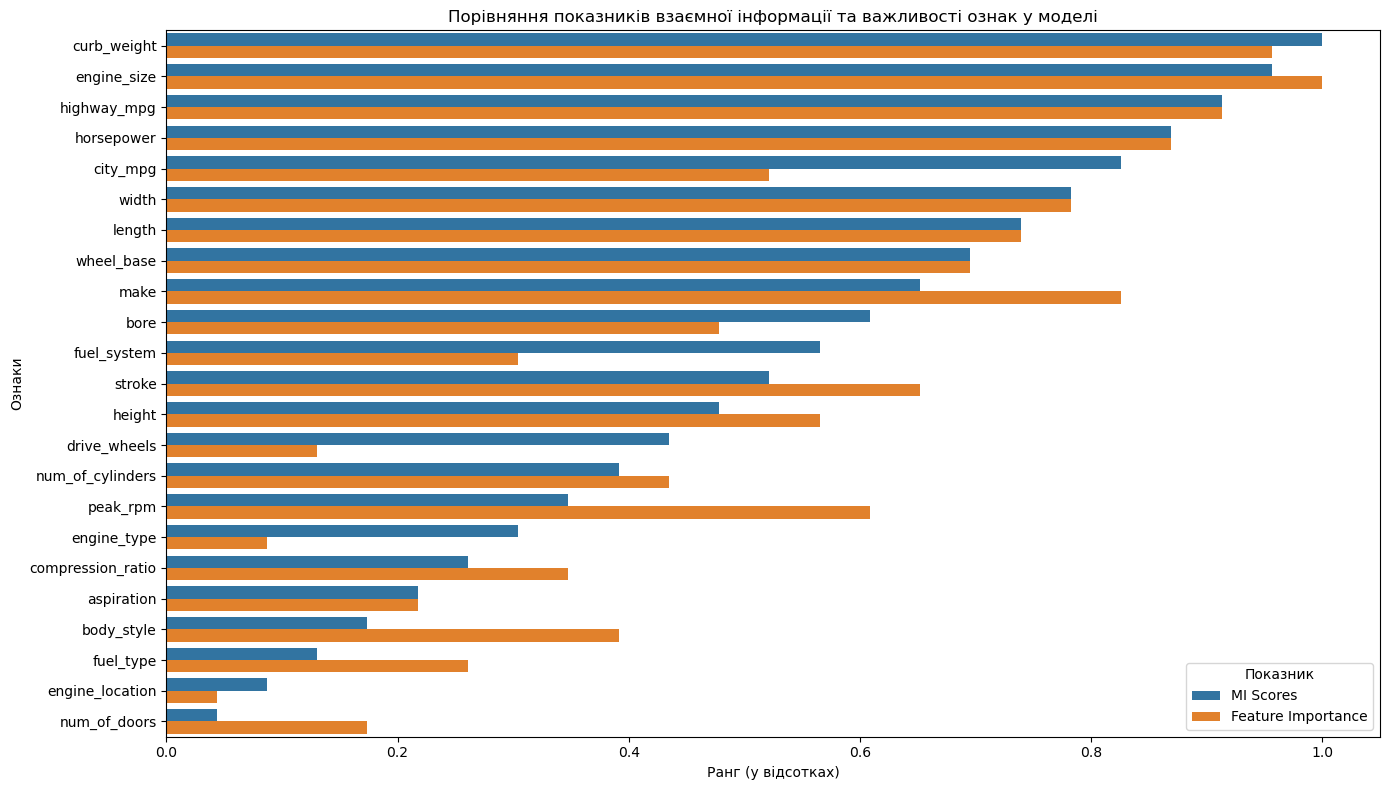

Топ-5 ознак за взаємною інформацією:
curb_weight    1.000000
engine_size    0.956522
highway_mpg    0.913043
horsepower     0.869565
city_mpg       0.826087
Name: MI Scores, dtype: float64

Топ-5 ознак за важливістю у моделі:
engine_size    1.000000
curb_weight    0.956522
highway_mpg    0.913043
horsepower     0.869565
make           0.826087
Name: Feature Importance, dtype: float64

Висновки:

1. Збіг важливих ознак:

У списках топ-5 ознак за взаємною інформацією (MI Scores) та важливістю в 
моделі (Feature Importance) є значний збіг. Зокрема, ознаки curb_weight, 
highway_mpg, engine_size та horsepower присутні в обох списках, що свідчить 
про їхню високу кореляцію з цільовою змінною price.
Це означає, що ці ознаки є дійсно релевантними для прогнозування ціни 
автомобіля, незалежно від методу оцінки.


2. Різниця у важливості ознак:
    
Замість ознаки city_mpg (міський пробіг), яка є у топ-5 за показником взаємної
інформації, у топ-5 за важливістю в моделі з’являється ознака make (в

In [2]:
import pandas as pd
import pickle
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# %% 1. Завантаження набору даних
with open('../datasets/mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

# %% Вибір потрібного набору даних
autos = datasets['autos']
X = autos.copy()
y = X.pop('price')

# Виведення перших 5 рядків для перевірки результату.
print(autos.head())
print(autos.info())

# %% 2. Визначення дискретних ознак
# Визначення категоріальних ознак
cat_features = X.select_dtypes(include=['object']).columns

# Визначення дискретних числових ознак (якщо вони є)
discrete_numerical_features = ['num_of_doors', 'num_of_cylinders']  # Додаткові числові дискретні ознаки
discrete_features = cat_features.to_list() + discrete_numerical_features

# %% 3. Кодування дискретних ознак
# Кодування категоріальних ознак за допомогою .factorize()
for col in cat_features:
    X[col], _ = X[col].factorize()

# %% 4. Розрахунок взаємної інформації з урахуванням дискретних ознак
mi_scores = mutual_info_regression(
    X, y,
    discrete_features=X.columns.isin(discrete_features)
)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns).sort_values(ascending=False)

# %% 5. Побудова регресійної моделі для оцінки важливості ознак
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Оцінка важливості ознак у моделі
feature_importances = pd.Series(model.feature_importances_, name='Feature Importance', index=X.columns).sort_values(ascending=False)

# %% 6. Масштабування та уніфікація показників за допомогою ранжування
mi_scores_ranked = mi_scores.rank(pct=True)
feature_importances_ranked = feature_importances.rank(pct=True)

# %% 7. Підготовка даних для порівняння
comparison_df = pd.DataFrame({
    'MI Scores': mi_scores_ranked,
    'Feature Importance': feature_importances_ranked
}).reset_index().rename(columns={'index': 'Feature'})

# %% 8. Сортування за показником MI Scores
comparison_df = comparison_df.sort_values(by='MI Scores', ascending=False)

# %% 9. Перетворення даних у формат "довгого" типу за допомогою melt()
comparison_melted = comparison_df.melt(id_vars='Feature', var_name='Metric', 
value_name='Rank')

# %% 10. Побудова графіка порівняння рангових показників
plt.figure(figsize=(14, 8))
sns.barplot(x='Rank', y='Feature', hue='Metric', data=comparison_melted, dodge=True)
plt.title('Порівняння показників взаємної інформації та важливості ознак у моделі')
plt.xlabel('Ранг (у відсотках)')
plt.ylabel('Ознаки')
plt.legend(title='Показник')
plt.tight_layout()
plt.show()

# %% 11. Топ-5 ознак за взаємною інформацією
print("Топ-5 ознак за взаємною інформацією:")
print(mi_scores_ranked.sort_values(ascending=False).head())

# %% 12. Топ-5 ознак за важливістю в моделі
print("\nТоп-5 ознак за важливістю у моделі:")
print(feature_importances_ranked.sort_values(ascending=False).head())

# %% 13. Висновки
print('''\nВисновки:
\n1. Збіг важливих ознак:

У списках топ-5 ознак за взаємною інформацією (MI Scores) та важливістю в 
моделі (Feature Importance) є значний збіг. Зокрема, ознаки curb_weight, 
highway_mpg, engine_size та horsepower присутні в обох списках, що свідчить 
про їхню високу кореляцію з цільовою змінною price.
Це означає, що ці ознаки є дійсно релевантними для прогнозування ціни 
автомобіля, незалежно від методу оцінки.

\n2. Різниця у важливості ознак:
    
Замість ознаки city_mpg (міський пробіг), яка є у топ-5 за показником взаємної
інформації, у топ-5 за важливістю в моделі з’являється ознака make (виробник 
автомобіля). Це вказує на те, що модель RandomForestRegressor враховує 
важливість ознаки make, навіть якщо вона має нижчий показник взаємної 
інформації з цільовою змінною. Можливо, make впливає на ціну автомобіля через 
взаємодію з іншими ознаками, які модель успішно ідентифікує.

\n3. Аналіз кожної ознаки:

\n- curb_weight (Споряджена маса автомобіля):
Найвищий показник взаємної інформації та один із найвищих показників важливості. 
Це логічно, оскільки маса автомобіля безпосередньо пов'язана з вартістю 
через технічні характеристики та витрати на виробництво.

\n- engine_size (Об’єм двигуна):
Найвища важливість у моделі та третя за взаємною інформацією. Об’єм двигуна 
є ключовим фактором, що впливає на потужність автомобіля, а також на вартість.

\n- highway_mpg (Витрати палива на шосе):
Високий показник взаємної інформації та важливості в моделі. Це може бути 
пов’язано з тим, що автомобілі з більш ефективними витратами палива мають 
різну вартість на ринку, що впливає на кінцеву ціну.

\n- horsepower (Кінські сили):
Високий показник за обома метриками. Це важливий параметр продуктивності 
автомобіля, який прямо впливає на його ціну.

\n- make (Виробник автомобіля):
Входить у топ-5 за важливістю моделі, але не має високого показника взаємної 
інформації. Це означає, що ознака make може мати взаємозв’язки з іншими 
ознаками, які модель враховує під час прогнозування ціни. Наприклад, 
автомобілі відомих брендів можуть мати вищу ціну, навіть якщо їхні технічні 
характеристики такі ж, як у менш відомих виробників.

\n- Важливість взаємної інформації:

Високі показники взаємної інформації (curb_weight, highway_mpg, engine_size, 
horsepower, city_mpg) свідчать про те, що ці ознаки мають лінійну або близьку 
до лінійної залежність з ціною автомобіля.
Однак взаємна інформація не враховує взаємодію ознак, тому такі категоріальні
ознаки, як make, можуть бути недооцінені, якщо використовувати лише взаємну 
інформацію.

\n- Рекомендації для подальшого аналізу:

Врахувати взаємодію категоріальних та числових ознак у моделі. 
Можна додатково розглянути методи об’єднання ознак (feature engineering) 
для поліпшення якості моделі.
Проаналізувати залежність цільової змінної від ознак, які не увійшли до топ-5,
щоб з’ясувати, чи є можливість створення нових, більш інформативних ознак.

\n- Загальний висновок:
    
Комбінація показників взаємної інформації та важливості у моделі допомагає 
краще зрозуміти релевантність ознак для задачі прогнозування. 
Модель може ідентифікувати приховані залежності, які не виявляються через 
взаємну інформацію, тому для комплексного аналізу варто використовувати 
обидва методи оцінки важливості ознак.''')
